# Stock Trading App Tutorial Part 16-17

## Part 16: [Position Sizing, Liquidation](https://www.youtube.com/watch?v=C5xBEiRLzpg&list=PLvzuUVysUFOuoRna8KhschkVVUo2E2g6G&index=17)
- Manage risk by calculating position sizings that are manageable for given account.
- Schedule to liquidate positions towards the end of the day to avoid holding overnight, especially if price never hits limit price or stop loss.
- Timescale DB (https://www.timescale.com)
    - Database specifically built for time series data.
    - Working with lots of timestamped price data.
    - WARNING: Paid service (https://www.timescale.com/pricing)
    - Built on top of PostgreSQL.

### Position Sizing 
- e.g. $\$100000$ in account, $\$400000$ of buying power; execute trade on Amazon stock, script designed such that 100 stock bought regardless of price; all buying power banked on Amazon, while other stocks in basket would be rejected.
- Plan: Ensure no stock takes up >10% of portfolio.
- Create simple function to achieve such.
- `helpers.py`
```python
import math 
PAPER_AMT = 100000
def calculate_quantity(price): 
    quantity = math.floor(PAPER_AMT/price)
    return quantity
```
- `opening_range_breakout.py`
```python
# ... 
try: 
    api.submit_order(
        symbol=symbol,
        side='buy',
        type='limit',
        # qty='100',
        qty=calculate_quantity(limit_price),
        time_in_force='day',
        order_class='bracket',
        limit_price=limit_price,
        take_profit=dict(
            limit_price=limit_price + opening_range,
        ),
        stop_loss=dict(
            stop_price=limit_price - opening_range,
        )
    )
except Exception as e:
# ...
```

### Liquidation
- No guarantee that position will be filled at the instant of the closing bell, will fill at 15-30 min before with scheduled task `daily_close.py`.
```python
import alpaca_trade_api as tradeapi
import config 

api = tradeapi.REST(config.API_KEY, config.SECRET_KEY, base_url = config.API_URL, api_version = "v2") # config.py variables 
response = api.close_all_positions()
print(response)
```
- cron
```cron
30 3 * * 1-5 /opt/anaconda3/bin/python /Users/student/Documents\ –\ SNG058/Self-Learning/Algo\ Trading\ Models/Stock\ Trading\ App\ Tutorial/daily_close.py >> /Users/student/Documents\ –\ SNG058/Self-Learning/Algo\ Trading\ Models/Stock\ Trading\ App\ Tutorial/trade.log 2>&1
```

## Part 17: [Trailing Stop Orders, ATR](https://www.youtube.com/watch?v=NZJhbbeJyhs&list=PLvzuUVysUFOuoRna8KhschkVVUo2E2g6G&index=18)
### Trailing Stop Orders (https://alpaca.markets/blog/trailing-stop/)
- Were intially working with fixed limit price and stop loss.
- Trailing stop allows stock to run for a bit after reaching limit price.
- High-water mark: Highest peak in value reached by account or investment fund.
- e.g. Buy NIO stock, enters position at $\$45$ per share = High-water mark (HWM).
    - Trailing stop amount/percentage set such that if HWM increases, stop loss trails behind to ensure difference is constant.
    - Trailing stop amount of $\$X$ -> Stop loss set at $HWM - \$5$ (e.g. High-water mark increased to $\$60$ -> Stop loss = $\$55$)
    - Trailing stop percent of $X\%$ -> Stop loss set at $HWM * (100 - X)\%$ (e.g. High-water mark increased to $\$60$ -> Stop loss = $\$54$)
- `trailing_stop.py`
    - Set up API and symbols.
    - Buy market bracket order for each symbol.
    - Enter trailing stop sell orders for each buy order; probably want to sell only half of them by one stop, other half by trailing stop
    - Set `type='trailing_stop'`, then either `trail_price` or `trail_percent` (`trail_percent` may be safer given changing price values).
```python
import config 
import alpaca_trade_api as tradeapi
from helpers import calculate_quantity

api = tradeapi.REST(config.API_KEY, config.SECRET_KEY, base_url = config.API_URL, api_version = "v2") # config.py variables 

symbols = [] # FILL THIS IN WITH SYMBOLS OF INTEREST

for symbol in symbols: 
    quote = api.get_last_quote(symbol)
    try: 
        api.submit_order(
            symbol=symbol,
            side='buy',
            type='market',
            # qty='100',
            qty=calculate_quantity(quote.bidprice),
            time_in_force='day',
            order_class='bracket',
        )
    except Exception as e:
        print(f"Cannot submit order {e}")

orders = api.list_orders()
positions = api.list_positions()

for symbol in symbols: 
    try: 
        api.submit_order(
            symbol=symbol,
            side='sell',
            type='trailing_stop',
            qty=calculate_quantity(quote.bidprice)/2,
            time_in_force='day',
            trail_price=0.5
        ) 
    except Exception as e:
        print(f"Cannot submit order {e}")
        
for symbol in symbols: 
    try: 
        api.submit_order(
            symbol=symbol,
            side='sell',
            type='trailing_stop',
            qty=calculate_quantity(quote.bidprice)/2,
            time_in_force='day',
            trail_percent=0.75
        ) 
    except Exception as e:
        print(f"Cannot submit order {e}")
```
### Average True Range (ATR) (`talib.ATR()`)
- Used for calcualting stop-loss by being used as trailing stop value.
- Accessible through TradingView chart.
- Calculation of volatility by looking at true range (How much stock moved each day), averaged over last 14 days.
- e.g. NIO
    - Volatility relatively constant for October.
    - As of end of October, volatility drastically increases.
    - Very large candlesticks later down the line.
- Use `get_day_data()`, modified form of `get_minute_data()`
```python
import config 
import alpaca_trade_api as tradeapi
from helpers import calculate_quantity
from get_minute_data import get_minute_data

api = tradeapi.REST(config.API_KEY, config.SECRET_KEY, base_url = config.API_URL, api_version = "v2") # config.py variables 

symbols = [] # FILL THIS IN WITH SYMBOLS OF INTEREST

def get_day_data(ticker):
    ts = TimeSeries(key=config.API_KEY, output_format='pandas', indexing_type='date')
    df, _ = ts.get_daily(ticker, outputsize='full') # FOR TESTING
    df.rename(columns={"1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close", "5. volume": "volume",  "date": "date"}, inplace=True)
    df = df.iloc[::-1]
    return df

for symbol in symbols: 
    daily_bars = get_day_data(symbol)
    atr = talib.ATR(daily_bars.high.value, daily_bars.low.value, daily_bars.close.value, timeperiod=14)
    print(atr)
```

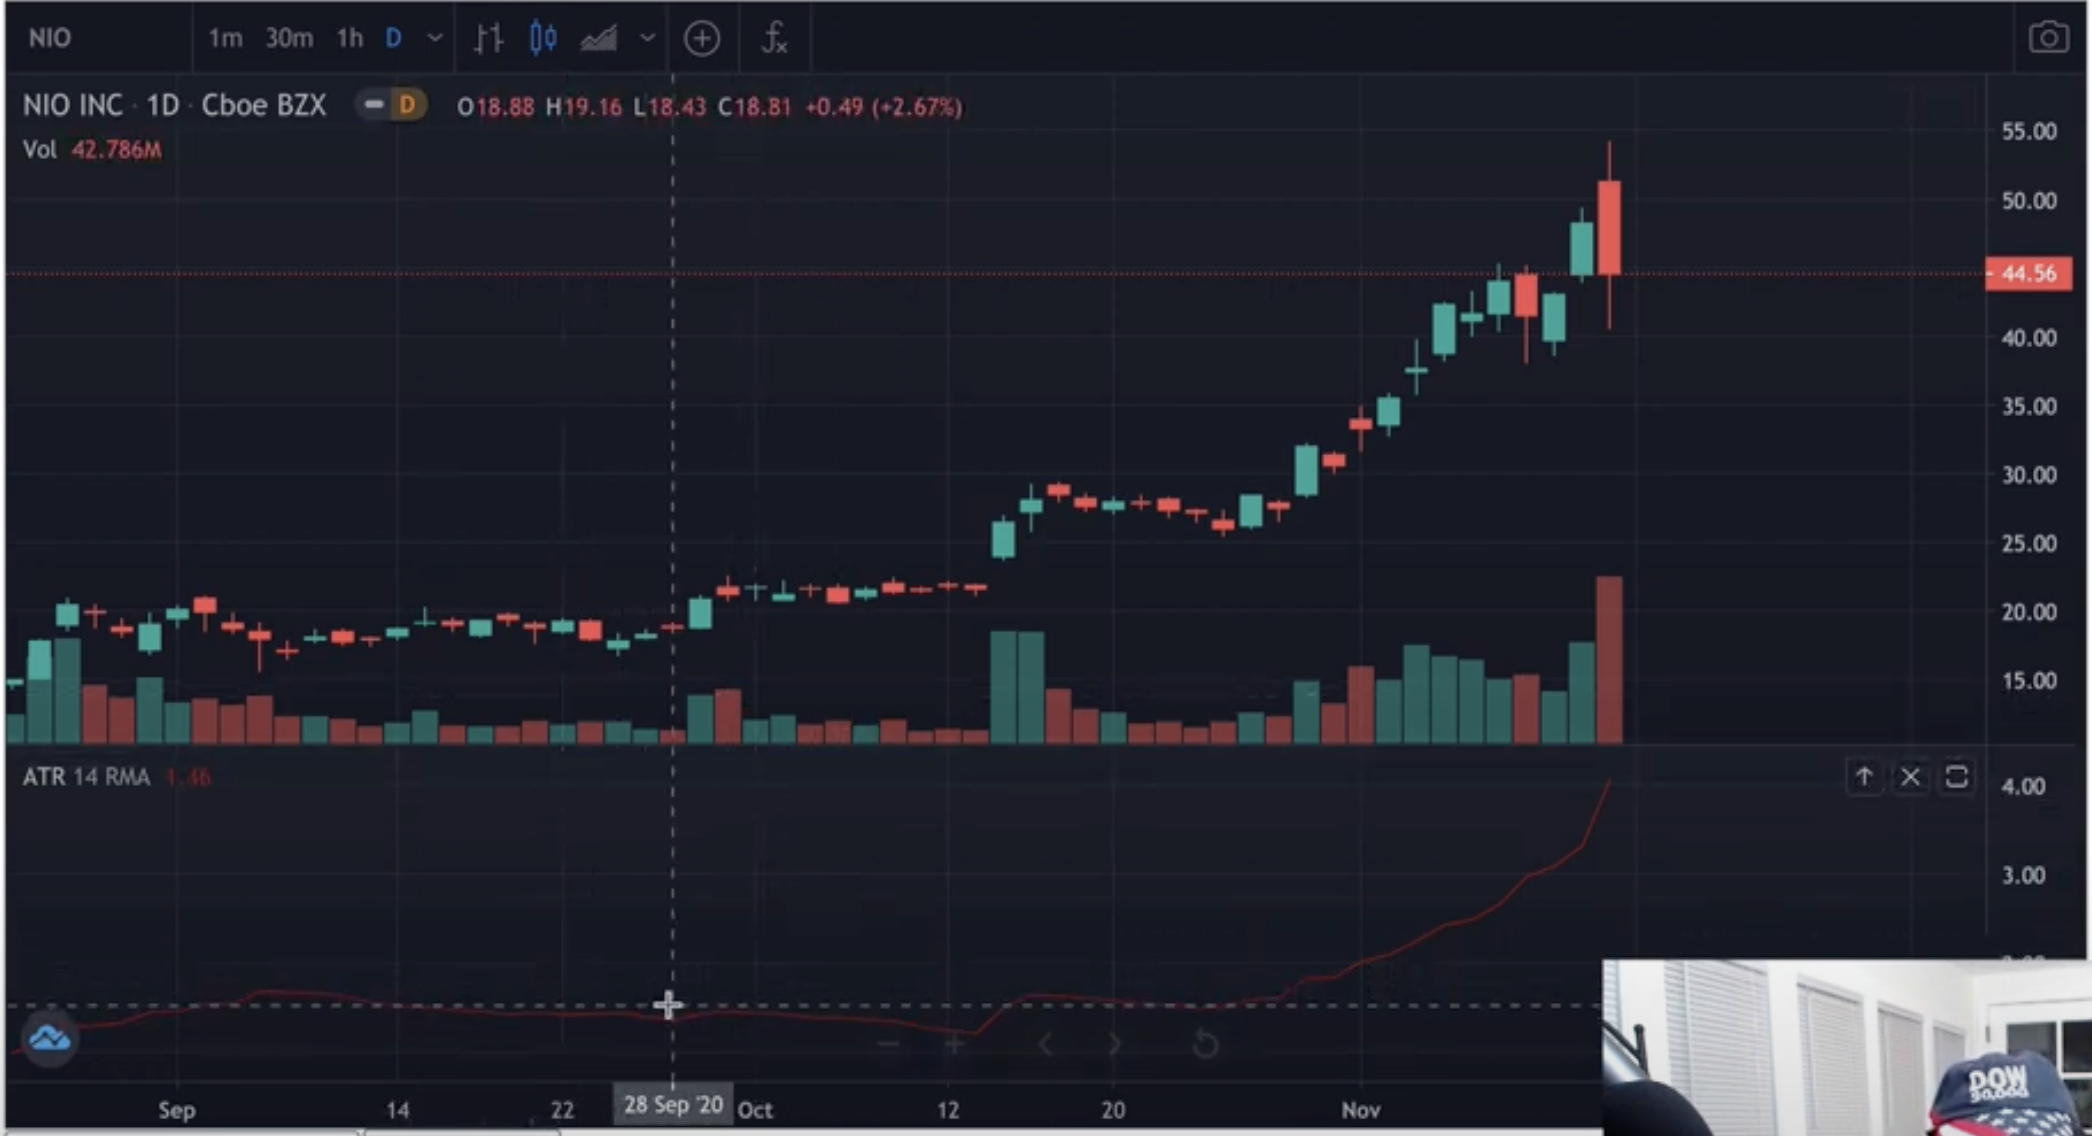